In [1]:
import kagglehub

#path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

#print("Path to dataset files:", path)

/home/anderson_walsh/UTK/COSC523Project2/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = '/home/anderson_walsh/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training'
test = '/home/anderson_walsh/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing'

In [3]:
import cv2
import numpy as np
import os

DATASET_PATH = '/home/anderson_walsh/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/'

IMG_SIZE = 224

labels_map = {
    'glioma': 0,
    'meningioma': 1,
    'pituitary': 2,
    'notumor': 3  
}

def load_data(folder):
    X = []
    y = []
    for label in labels_map.keys():
        class_folder = os.path.join(folder, label)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                X.append(img)
                y.append(labels_map[label])
            except:
                print(f"Skipped corrupt image: {img_path}")
    return np.array(X), np.array(y)


In [4]:
X_train, y_train = load_data(os.path.join(DATASET_PATH, 'Training'))

X_test, y_test = load_data(os.path.join(DATASET_PATH, 'Testing'))

print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (5712, 224, 224) (5712,)
Testing set: (1311, 224, 224) (1311,)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [6]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

2025-05-04 18:50:36.697557: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 18:50:36.863580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746399036.921334  444524 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746399036.938437  444524 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-04 18:50:37.084320: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [7]:
import tensorflow as tf
import numpy as np
def data_generator():
    for img, label in zip(X_train, y_train):
        img_array = np.array(img, dtype=np.uint8)
        yield img_array, label
def data_generator_val():
    for img, label in zip(X_val, y_val):
        img_array = np.array(img, dtype=np.uint8)
        yield img_array, label
train_ds = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(224, 224), dtype=tf.uint8),
        tf.TensorSpec(shape=(4,), dtype=tf.uint8)
    )
)
val_ds = tf.data.Dataset.from_generator(
    data_generator_val,
    output_signature=(
        tf.TensorSpec(shape=(224, 224), dtype=tf.uint8),
        tf.TensorSpec(shape=(4,), dtype=tf.uint8)
    )
)

I0000 00:00:1746399038.960765  444524 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [8]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomWidth, RandomHeight, RandomZoom


data_augmentation = tf.keras.Sequential([
    RandomRotation(0.2),
    RandomWidth(0.2),
    RandomHeight(0.2),
    RandomZoom(0.2),
])


In [9]:
def preprocess(img, label):
    img = tf.expand_dims(img, axis=-1)
    img = tf.image.grayscale_to_rgb(img)
    img = tf.cast(img, tf.float32) / 255.0
    label = tf.cast(label, tf.float32)
    return img, label
def preprocess_train(img, label):
    img = tf.expand_dims(img, axis=-1)
    img = tf.image.grayscale_to_rgb(img)
    img = tf.cast(img, tf.float32) / 255.0
    #img = data_augmentation(img)
    #img = tf.image.resize(img, (224, 224))
    label = tf.cast(label, tf.float32)
    return img, label

In [10]:
train_ds = (
    train_ds
    .map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    val_ds
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

inputs = Input(shape=(224, 224, 3))


x = inputs

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model(x, training=False)

# Custom classification head
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(4, activation='sigmoid')(x)

model = Model(inputs, outputs)

In [12]:
from tensorflow.keras.metrics import AUC
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
	metrics=['accuracy']
)

In [13]:
from tensorflow.keras import callbacks
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True, min_delta=0.001, monitor='val_accuracy', mode='max')
reduce_lr = callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50


I0000 00:00:1746399045.550460  444687 service.cc:148] XLA service 0x7fa6a4001a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746399045.550663  444687 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-05-04 18:50:45.726993: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746399046.822358  444687 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-04 18:50:47.677460: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11125_0', 100 bytes spill stores, 100 bytes spill loads

2025-05-04 18:50:47.813997: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18652', 24

      5/Unknown 13s 31ms/step - accuracy: 0.2678 - loss: 0.7169

I0000 00:00:1746399054.180211  444687 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    138/Unknown 15s 14ms/step - accuracy: 0.4651 - loss: 0.5156

2025-05-04 18:50:57.784793: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11125', 112 bytes spill stores, 112 bytes spill loads

2025-05-04 18:50:57.793258: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11125_0', 360 bytes spill stores, 468 bytes spill loads

2025-05-04 18:50:57.819786: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18652', 24 bytes spill stores, 24 bytes spill loads

2025-05-04 18:50:57.843601: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18652', 12 bytes spill stores, 16 bytes spill loads

2025-05-04 18:50:57.846319: I external/local_xla/x

    143/Unknown 22s 66ms/step - accuracy: 0.4699 - loss: 0.5121

2025-05-04 18:51:03.605107: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-04 18:51:03.605215: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2025-05-04 18:51:05.956253: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3314_0', 88 bytes spill stores, 120 bytes spill loads

2025-05-04 18:51:06.470719: I external/local_xla/xla/s

143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 154ms/step - accuracy: 0.4708 - loss: 0.5114 - val_accuracy: 0.8206 - val_loss: 0.2333
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7885 - loss: 0.2665 - val_accuracy: 0.8644 - val_loss: 0.1766
Epoch 3/50
  5/143 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7991 - loss: 0.2485

2025-05-04 18:51:18.468293: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-04 18:51:18.468342: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12718303120688300133
2025-05-04 18:51:18.468346: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17337960464386849339


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8448 - loss: 0.2080 - val_accuracy: 0.8906 - val_loss: 0.1523
Epoch 4/50
  6/143 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8479 - loss: 0.1979

2025-05-04 18:51:20.809426: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12718303120688300133
2025-05-04 18:51:20.809481: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17337960464386849339


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8705 - loss: 0.1768 - val_accuracy: 0.9046 - val_loss: 0.1326
Epoch 5/50
  1/143 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8438 - loss: 0.2142

2025-05-04 18:57:25.585716: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-04 18:57:25.585759: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12718303120688300133
2025-05-04 18:57:25.585763: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17337960464386849339


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8841 - loss: 0.1566 - val_accuracy: 0.9081 - val_loss: 0.1219
Epoch 6/50
  6/143 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9175 - loss: 0.1582

2025-05-04 18:51:25.499049: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12718303120688300133


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9003 - loss: 0.1429 - val_accuracy: 0.9160 - val_loss: 0.1142
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9068 - loss: 0.1293 - val_accuracy: 0.9230 - val_loss: 0.1088
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9180 - loss: 0.1177 - val_accuracy: 0.9326 - val_loss: 0.0994
Epoch 9/50
  1/143 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9062 - loss: 0.1582

2025-05-04 18:51:32.502071: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-04 18:51:32.502114: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12718303120688300133
2025-05-04 18:51:32.502118: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17337960464386849339


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9192 - loss: 0.1103 - val_accuracy: 0.9361 - val_loss: 0.0957
Epoch 10/50
  2/143 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8984 - loss: 0.1702

2025-05-04 18:51:34.828714: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12718303120688300133
2025-05-04 18:51:34.828759: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17337960464386849339


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9244 - loss: 0.1047 - val_accuracy: 0.9361 - val_loss: 0.0910
Epoch 11/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9325 - loss: 0.0953 - val_accuracy: 0.9405 - val_loss: 0.0883
Epoch 12/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9372 - loss: 0.0919 - val_accuracy: 0.9344 - val_loss: 0.0863
Epoch 13/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9441 - loss: 0.0804 - val_accuracy: 0.9414 - val_loss: 0.0831
Epoch 14/50
 11/143 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9700 - loss: 0.0642

2025-05-04 18:51:43.979358: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12718303120688300133


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9515 - loss: 0.0742 - val_accuracy: 0.9388 - val_loss: 0.0808
Epoch 15/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9472 - loss: 0.0708 - val_accuracy: 0.9458 - val_loss: 0.0777
Epoch 16/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9540 - loss: 0.0672 - val_accuracy: 0.9440 - val_loss: 0.0785
Epoch 17/50
 11/143 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9649 - loss: 0.0539

2025-05-04 18:51:50.842771: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 365s 3s/step - accuracy: 0.9589 - loss: 0.0578 - val_accuracy: 0.9484 - val_loss: 0.0745
Epoch 18/50
  1/143 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9375 - loss: 0.0643

2025-05-04 18:51:53.091794: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12718303120688300133
2025-05-04 18:51:53.091837: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17337960464386849339


143/143 ━━━━━━━━━━━━━━━━━━━━ -360s -2537111us/step - accuracy: 0.9597 - loss: 0.0568 - val_accuracy: 0.9466 - val_loss: 0.0707
Epoch 19/50
 10/143 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9520 - loss: 0.0616

2025-05-04 18:51:55.405882: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12718303120688300133
2025-05-04 18:51:55.405927: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17337960464386849339


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9674 - loss: 0.0503 - val_accuracy: 0.9414 - val_loss: 0.0732
Epoch 20/50
  9/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9812 - loss: 0.0390

2025-05-04 18:51:57.668270: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12718303120688300133
2025-05-04 18:51:57.668305: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17337960464386849339


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9700 - loss: 0.0448 - val_accuracy: 0.9423 - val_loss: 0.0725
Epoch 21/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9704 - loss: 0.0474 - val_accuracy: 0.9405 - val_loss: 0.0780
Epoch 22/50
  9/143 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9606 - loss: 0.0668

2025-05-04 18:52:02.602887: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12718303120688300133
2025-05-04 18:52:02.602924: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17337960464386849339


143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9687 - loss: 0.0498 - val_accuracy: 0.9484 - val_loss: 0.0677


In [ ]:
classifier_head_weights = [layer.get_weights() for layer in model.layers[-8:]]

In [16]:
base_model.trainable = True

for layer in base_model.layers[:-80]:
    layer.trainable = False

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='binary_crossentropy',
	metrics=['accuracy']
)

In [18]:
for i, layer in enumerate(model.layers[-8:]):
    layer.set_weights(classifier_head_weights[i])

In [19]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[reduce_lr]
)

Epoch 1/50


2025-05-04 18:52:15.259772: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17876', 104 bytes spill stores, 104 bytes spill loads

2025-05-04 18:58:20.636662: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_88578__.25824] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-05-04 18:58:25.659188: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 6m8.010425569s

********************************
[Compiling module a_inference_one_step_on_data_88578__.25824] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


    141/Unknown 20s 15ms/step - accuracy: 0.5981 - loss: 0.7952

2025-05-04 18:58:30.653645: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng48{k2=2,k6=0,k13=2,k14=0,k22=2} for conv (f32[25,864,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,128,7,7]{3,2,1,0}, f32[864,128,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-04 18:58:30.655567: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 6m2.446487902s
Trying algorithm eng48{k2=2,k6=0,k13=2,k14=0,k22=2} for conv (f32[25,864,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,128,7,7]{3,2,1,0}, f32[864,128,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_c

    143/Unknown 30s 84ms/step - accuracy: 0.5985 - loss: 0.7942

2025-05-04 18:58:40.659298: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_94506__.3453] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - accuracy: 0.5986 - loss: 0.7937 - val_accuracy: 0.8880 - val_loss: 0.1720 - learning_rate: 1.0000e-06
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7025 - loss: 0.4872 - val_accuracy: 0.8635 - val_loss: 0.2038 - learning_rate: 1.0000e-06
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7739 - loss: 0.3211 - val_accuracy: 0.8915 - val_loss: 0.1671 - learning_rate: 1.0000e-06
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8482 - loss: 0.2169 - val_accuracy: 0.9090 - val_loss: 0.1390 - learning_rate: 1.0000e-06
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8687 - loss: 0.1859 - val_accuracy: 0.9160 - val_loss: 0.1240 - learning_rate: 1.0000e-06
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8741 - loss: 0.1656 - val_accuracy: 0.9248 - val_loss: 0.1162 - learning_rate: 1.0000e-06
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.

2025-05-04 18:53:06.697059: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9143 - loss: 0.1226 - val_accuracy: 0.9379 - val_loss: 0.1021 - learning_rate: 1.0000e-06
Epoch 12/50
141/143 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9118 - loss: 0.1257

2025-05-04 18:53:11.575791: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12718303120688300133
2025-05-04 18:53:11.575861: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17337960464386849339


143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9117 - loss: 0.1257 - val_accuracy: 0.9405 - val_loss: 0.1004 - learning_rate: 1.0000e-06
Epoch 13/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9194 - loss: 0.1097 - val_accuracy: 0.9405 - val_loss: 0.0996 - learning_rate: 1.0000e-06
Epoch 14/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9259 - loss: 0.1069 - val_accuracy: 0.9440 - val_loss: 0.0980 - learning_rate: 1.0000e-06
Epoch 15/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9246 - loss: 0.1017 - val_accuracy: 0.9440 - val_loss: 0.0966 - learning_rate: 1.0000e-06
Epoch 16/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9212 - loss: 0.1082 - val_accuracy: 0.9449 - val_loss: 0.0953 - learning_rate: 1.0000e-06
Epoch 17/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9250 - loss: 0.1090 - val_accuracy: 0.9475 - val_loss: 0.0939 - learning_rate: 1.0000e-06
Epoch 18/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy

2025-05-04 18:59:40.796165: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12718303120688300133
2025-05-04 18:59:40.796501: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17337960464386849339


143/143 ━━━━━━━━━━━━━━━━━━━━ -360s -2534240us/step - accuracy: 0.9412 - loss: 0.0808 - val_accuracy: 0.9493 - val_loss: 0.0893 - learning_rate: 1.0000e-06
Epoch 24/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9397 - loss: 0.0844 - val_accuracy: 0.9484 - val_loss: 0.0886 - learning_rate: 1.0000e-06
Epoch 25/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9400 - loss: 0.0813 - val_accuracy: 0.9493 - val_loss: 0.0880 - learning_rate: 1.0000e-06
Epoch 26/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9508 - loss: 0.0722 - val_accuracy: 0.9493 - val_loss: 0.0872 - learning_rate: 1.0000e-06
Epoch 27/50
  9/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9311 - loss: 0.0875

2025-05-04 18:53:48.910241: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17337960464386849339


143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9426 - loss: 0.0765 - val_accuracy: 0.9493 - val_loss: 0.0863 - learning_rate: 1.0000e-06
Epoch 28/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9398 - loss: 0.0718 - val_accuracy: 0.9493 - val_loss: 0.0859 - learning_rate: 1.0000e-06
Epoch 29/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9491 - loss: 0.0700 - val_accuracy: 0.9493 - val_loss: 0.0852 - learning_rate: 1.0000e-06
Epoch 30/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9422 - loss: 0.0770 - val_accuracy: 0.9475 - val_loss: 0.0848 - learning_rate: 1.0000e-06
Epoch 31/50
  9/143 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9352 - loss: 0.0892

2025-05-04 18:53:59.464482: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17337960464386849339


143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9493 - loss: 0.0774 - val_accuracy: 0.9493 - val_loss: 0.0837 - learning_rate: 1.0000e-06
Epoch 32/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9470 - loss: 0.0723 - val_accuracy: 0.9493 - val_loss: 0.0835 - learning_rate: 1.0000e-06
Epoch 33/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9514 - loss: 0.0658 - val_accuracy: 0.9510 - val_loss: 0.0828 - learning_rate: 1.0000e-06
Epoch 34/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9521 - loss: 0.0668 - val_accuracy: 0.9519 - val_loss: 0.0817 - learning_rate: 1.0000e-06
Epoch 35/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9566 - loss: 0.0568 - val_accuracy: 0.9510 - val_loss: 0.0813 - learning_rate: 1.0000e-06
Epoch 36/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9557 - loss: 0.0617 - val_accuracy: 0.9510 - val_loss: 0.0806 - learning_rate: 1.0000e-06
Epoch 37/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy

2025-05-04 18:54:24.955200: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12718303120688300133
2025-05-04 18:54:24.955238: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17337960464386849339


143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9533 - loss: 0.0600 - val_accuracy: 0.9501 - val_loss: 0.0787 - learning_rate: 1.0000e-06
Epoch 41/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9606 - loss: 0.0528 - val_accuracy: 0.9501 - val_loss: 0.0784 - learning_rate: 1.0000e-06
Epoch 42/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9608 - loss: 0.0541 - val_accuracy: 0.9528 - val_loss: 0.0777 - learning_rate: 1.0000e-06
Epoch 43/50
  9/143 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9464 - loss: 0.0679

2025-05-04 18:54:32.850726: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9648 - loss: 0.0543 - val_accuracy: 0.9501 - val_loss: 0.0773 - learning_rate: 1.0000e-06
Epoch 44/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9649 - loss: 0.0502 - val_accuracy: 0.9501 - val_loss: 0.0771 - learning_rate: 1.0000e-06
Epoch 45/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9650 - loss: 0.0525 - val_accuracy: 0.9501 - val_loss: 0.0769 - learning_rate: 1.0000e-06
Epoch 46/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 365s 3s/step - accuracy: 0.9634 - loss: 0.0522 - val_accuracy: 0.9501 - val_loss: 0.0767 - learning_rate: 1.0000e-06
Epoch 47/50
143/143 ━━━━━━━━━━━━━━━━━━━━ -360s -2534275us/step - accuracy: 0.9685 - loss: 0.0457 - val_accuracy: 0.9501 - val_loss: 0.0762 - learning_rate: 1.0000e-06
Epoch 48/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9641 - loss: 0.0475 - val_accuracy: 0.9501 - val_loss: 0.0759 - learning_rate: 1.0000e-06
Epoch 49/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step -

In [ ]:
model.save("cnn_densenet_unfreeze.keras")
from tensorflow.keras.models import load_model
#model = load_model("cnn_densenet_unfreeze.keras")

In [21]:
test_ds = tf.data.Dataset.from_generator(
    data_generator_val,
    output_signature=(
        tf.TensorSpec(shape=(224, 224), dtype=tf.uint8),
        tf.TensorSpec(shape=(4,), dtype=tf.uint8)
    )
)
test_ds = (
   	test_ds 
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

2025-05-04 19:01:00.869228: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_137270__.3308] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


     32/Unknown 5s 13ms/step

2025-05-04 19:01:05.874761: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_142149__.3308] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


CNN Accuracy: 0.9501


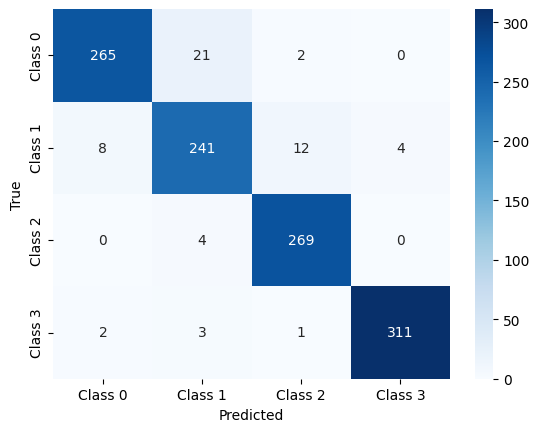

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(test_ds)

y_true = []
for _, label_batch in test_ds:
    y_true.append(label_batch.numpy())

y_true = np.concatenate(y_true, axis=0)

y_true = np.argmax(y_true, axis=1)

y_pred = np.argmax(y_pred, axis=1)

acc = accuracy_score(y_true, y_pred)
print(f"CNN Accuracy: {acc:.4f}")

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
acc = accuracy_score(y_true, y_pred)
print(f"CNN Accuracy: {acc:.4f}")

precision = precision_score(y_true, y_pred, average=None)  # per class precision
recall = recall_score(y_true, y_pred, average=None)  # per class recall
f1 = f1_score(y_true, y_pred, average=None)  # per class f1 score

print("Precision (per class):", precision)
print("Recall (per class):", recall)
print("F1 Score (per class):", f1)

precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print("\nOverall (macro average) Precision:", precision_macro)
print("Overall (macro average) Recall:", recall_macro)
print("Overall (macro average) F1 Score:", f1_macro)

report = classification_report(y_true, y_pred, target_names=["glioma", "meningioma", "pituitary", "notumor"])
print("\nClassification Report:\n", report)

CNN Accuracy: 0.9501
Precision (per class): [0.96363636 0.89591078 0.9471831  0.98730159]
Recall (per class): [0.92013889 0.90943396 0.98534799 0.98107256]
F1 Score (per class): [0.94138544 0.90262172 0.96588869 0.98417722]

Overall (macro average) Precision: 0.9485079575496613
Overall (macro average) Recall: 0.9489983479265182
Overall (macro average) F1 Score: 0.9485182656531487

Classification Report:
               precision    recall  f1-score   support

      glioma       0.96      0.92      0.94       288
  meningioma       0.90      0.91      0.90       265
   pituitary       0.95      0.99      0.97       273
     notumor       0.99      0.98      0.98       317

    accuracy                           0.95      1143
   macro avg       0.95      0.95      0.95      1143
weighted avg       0.95      0.95      0.95      1143



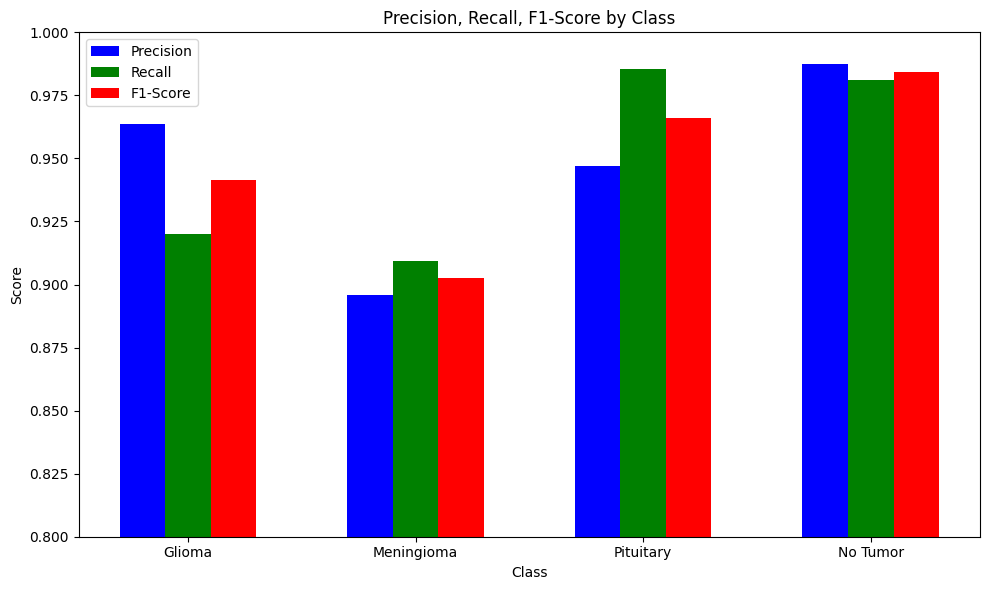

In [26]:
precision = [0.96363636, 0.89591078, 0.9471831,  0.98730159]
recall = [0.92013889, 0.90943396, 0.98534799, 0.98107256]
f1_score = [0.94138544, 0.90262172, 0.96588869, 0.98417722]

classes = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']

bar_width = 0.2
index = np.arange(len(classes))

fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index, precision, bar_width, label='Precision', color='blue')
bar2 = ax.bar(index + bar_width, recall, bar_width, label='Recall', color='green')
bar3 = ax.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-Score', color='red')


ax.set_ylim(0.8, 1)
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, F1-Score by Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()

In [25]:
import importlib.util
import subprocess

# --- Install pushbullet.py if it's not already present ---
if importlib.util.find_spec("pushbullet") is None:
    subprocess.run(["pip", "install", "pushbullet.py"])

# --- Pushbullet notification ---
try:
    from pushbullet import Pushbullet
    pb = Pushbullet("o.Dgrk9aBAsSvb3dJSzNaJlHJa7y5wv9R2")  # ⬅️ Replace with your real API key
    pb.push_note("✅ Training Complete", "Your notebook has finished running.")
    print("Pushbullet notification sent.")
except Exception as e:
    print("Pushbullet notification failed:", e)

Pushbullet notification sent.
